Welcome to the EPISOL Colab Playground!



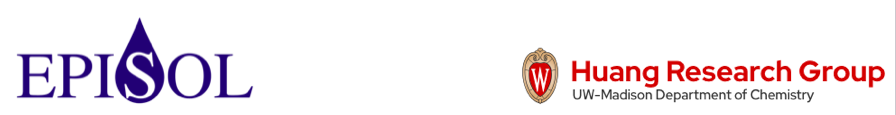

The 3D reference interaction site model (3DRISM) provides an efficient grid-based solvation model to compute the structural and thermodynamic properties of biomolecules in aqueous solutions, in this notebook we will walk through two examples: a neutral, and charged solute. In this notebook we will walk through a 3DRISM calculation on a larger solute - proteins, nucleic acids, and combininations thereof. T
* goals:
  * perform 3DRISM calculations on larger solutes using EPISOL utilizing the python interface
  * determine solvent distibutions around ares of interest
  * workthrough a calculation that fails to converge within the given number of steps
  * place explicit water - oxygens using commands specific to the python interface
  * determine high-energy waters and their importance

In [ ]:
#@markdown install episol kernel
#@title ##Download and Install Episol
#@markdown ($\approx 2$min) Stable as of 07/01/25 eprism v1.2.6
%%capture
#%cd ../home/
%cd $HOME/
%mkdir episol
%cd episol
!wget https://github.com/EPISOLrelease/EPISOL/raw/refs/heads/main/src/fftw/fftw-3.3.8.tar.gz
!echo "+++++++++++++++++++"
!echo "downloaded fftw files"
!echo "+++++++++++++++++++"
!tar -xzf fftw-3.3.8.tar.gz
%cd fftw-3.3.8/
#!./configure --prefix=/home/fftw-3.3.8
!./configure --prefix=$HOME/episol/fftw-3.3.8
!make
!make install
%cd ../
!wget https://github.com/EPISOLrelease/EPISOL/raw/refs/heads/main/src/kernel/release.tar.gz
!echo "+++++++++++++++++++"
!echo "downloaded Episol files"
!echo "+++++++++++++++++++"
!tar -xzf release.tar.gz
%cd release/
#!./configure --with-fftw=/home/fftw-3.3.8
!./configure --with-fftw=$HOME/episol/fftw-3.3.8
!make
!make install
%cd /content
########################### WRAPEPR

import matplotlib.pyplot as plt
!pip install episol


In [24]:
import numpy as np
from episol import epipy

#**Walk Through Calculation:**

First, we will download our desired structure file from the PDB

In [4]:
!wget https://raw.githubusercontent.com/EPISOLrelease/EPIPY/refs/heads/upload-notebooks/tutorials/6OUH.top
!wget https://raw.githubusercontent.com/EPISOLrelease/EPIPY/refs/heads/upload-notebooks/tutorials/fixed_6OUH.gro

--2025-09-09 20:23:26--  https://raw.githubusercontent.com/EPISOLrelease/EPIPY/refs/heads/upload-notebooks/tutorials/6OUH.top
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2276480 (2.2M) [text/plain]
Saving to: ‘6OUH.top’

6OUH.top            100%[===================>]   2.17M  --.-KB/s    in 0.07s   

2025-09-09 20:23:26 (29.1 MB/s) - ‘6OUH.top’ saved [2276480/2276480]

--2025-09-09 20:23:26--  https://raw.githubusercontent.com/EPISOLrelease/EPIPY/refs/heads/upload-notebooks/tutorials/fixed_6OUH.gro
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

In [5]:
pdb = epipy("fixed_6OUH.gro","6OUH.top",convert=True,gen_idc=True)
#pdb.solvent_path= 'episol/release/solvent/'

converted 6OUH.top to 6OUH.solute
generated idc-enabled solute file to: idc_6OUH.solute


* as before, we set our saved file name to one relevant as opposed to default names

In [6]:
pdb.report('6OUH')

In [7]:
pdb.rism(step=650,resolution=1)
pdb.err_tol = 1e-06 # we will set a higher tolerance than usual

* for this calculation, we can see that our grid shape is not totally cubic

In [8]:
pdb.grid


[55.0, 52.0, 62.0]

* lets test to get an estimate of how much RAM we will use

In [9]:
pdb.test()

'122.8MB'

* now we run!
* since we are using a bit of a larger solute, we will set our number of threads to 2, using the -nt flag
    * < 1min
  


In [10]:
pdb.kernel(nt=2)

Failed to reach desired err_tol of 1e-06
Actual error: 0.000128525
Difference: -0.000127525
RISM finished at step 650


* it looks like our calculation failed to converge within the given step size
* lets take a look at the output
* we will use the python interface to plot the SCF error as a function of step (iteration)

Text(0, 0.5, 'SCF')

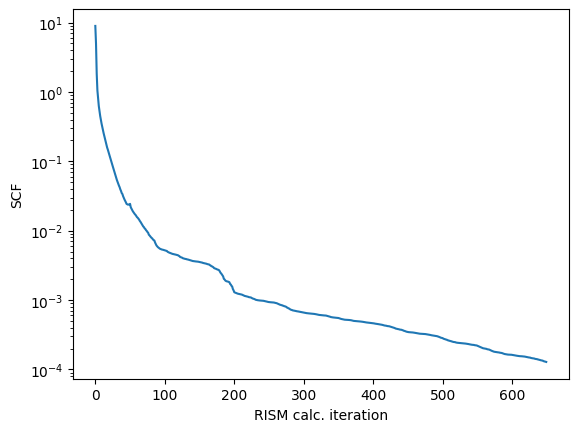

In [11]:
lscf_err = pdb.err()
fig,ax = plt.subplots()
ax.plot(lscf_err)
ax.set_yscale('log')
ax.set_xlabel('RISM calc. iteration')
ax.set_ylabel('SCF')


* our error tolerance isnt _that_ bad
* but its always better to have a smaller convergence value
* optimizes the self-consistent iterations by considering the
changes made in previous steps. The math form of an n-layer DIIS is
as follows:



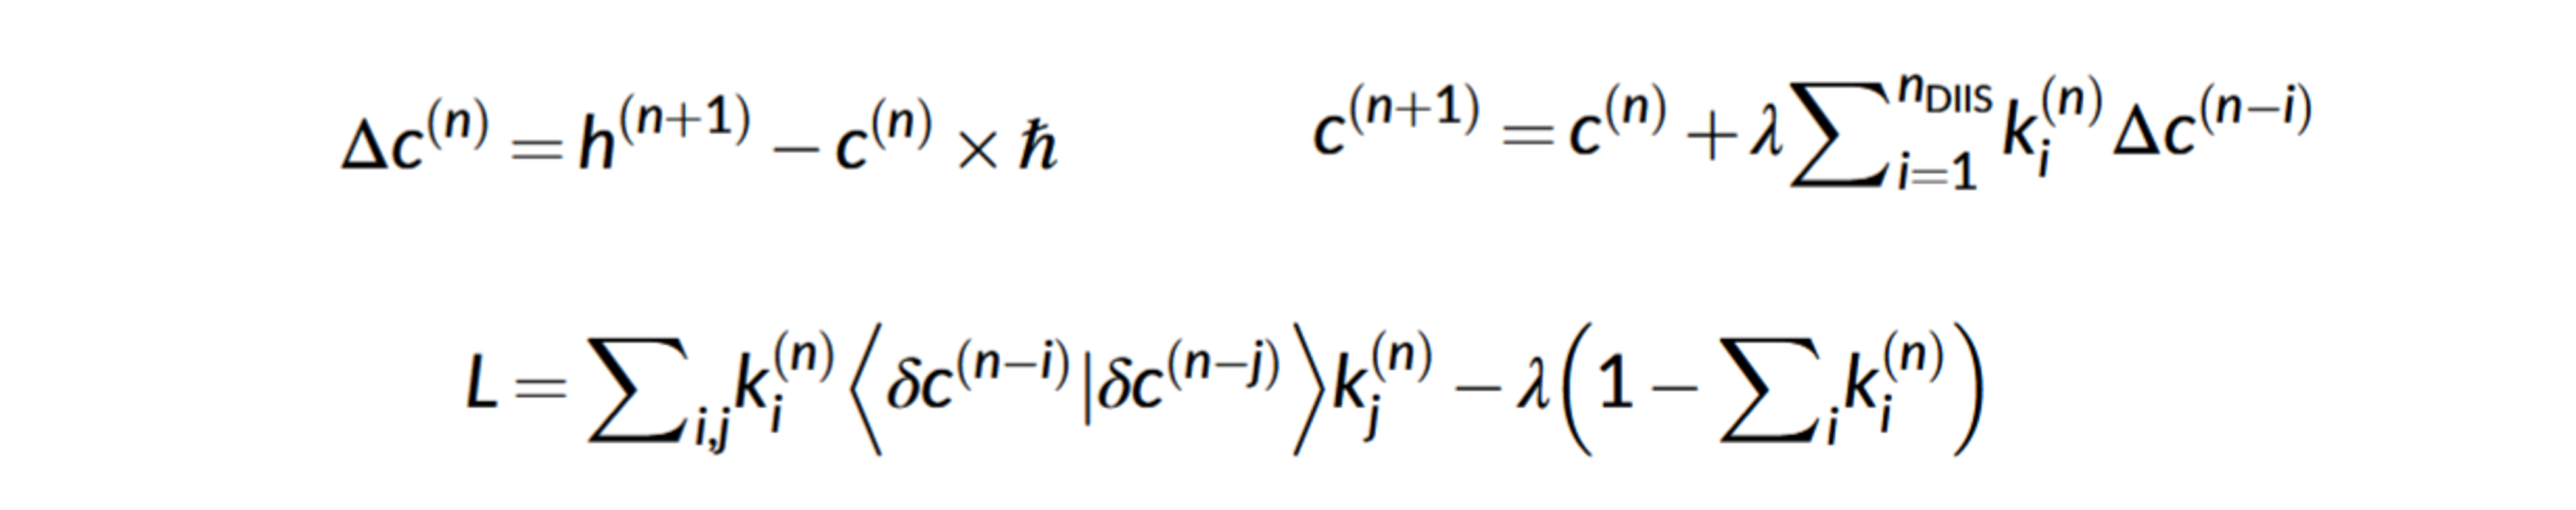

* where the factors $k_i^{n}$ are obtained by solving the DIIS Lagrange equation of historical changes for each grid (bottom)
* a 5-DIIS (std. value) would mean that we would consider the past values at the grid point for previous 5 cycles
* we can set the number of DIIS mixing steps to use
* this will cause our calculation to converge slower, but perhaps overcome local maxima

In [12]:
pdb.get_help('diis')

eprism3d 1.2.6 (c) 2022 Cao Siqin
111     -ndiisrism              (-ndiis) DIIS steps for RISM, default: 0 or 5
117     -ndiishi                (-ndiis) DIIS steps for HI, default: 0 or 5
 # EPRISM3D is free software. You can use, modify or redistribute under the
 # terms of the GNU Lesser General Public License v3:
 # https://www.gnu.org/licenses/lgpl-3.0.en.html


* just use the flag shown in the help function to set the parameter i.e. -ndiis means we call .ndiis

In [13]:
pdb.ndiis = 15
pdb.report('diis_increase_pdb')

* increasing the N-DIIS will also increase our allocated RAM usage

In [14]:
pdb.test()

'204.0MB'

* lets run now with increased DIIS (< 1min)
* since we are have a larger solute, we will use al available threads (2)

In [15]:
pdb.kernel(nt=2)

Calculation finished in 471 steps 
err_tol: 1e-06 actual: 9.97823e-07 


* comparing the error of the two runs we can see that increasing the DIIS also increases our convergence rate and helps mainintain a 'smoother' error curve

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3434317665.py:3: SyntaxWarning: invalid escape sequence '\d'
  ax.plot(lscf_err,label="$\delta^{SCF}$ NDIIS = 5 (stnd.)")
/tmp/ipython-input-3434317665.py:4: SyntaxWarning: invalid escape sequence '\d'
  ax.plot(diis_scf_err,label=f"$\delta^{{SCF}}$ NDIIS = {pdb.ndiis}")


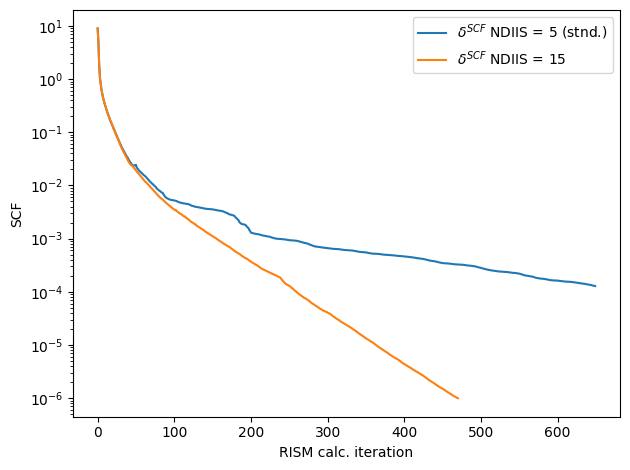

In [16]:
diis_scf_err = pdb.err()
fig,ax = plt.subplots()
ax.plot(lscf_err,label="$\delta^{SCF}$ NDIIS = 5 (stnd.)")
ax.plot(diis_scf_err,label=f"$\delta^{{SCF}}$ NDIIS = {pdb.ndiis}")
ax.set_yscale('log')
ax.set_xlabel('RISM calc. iteration')
ax.set_ylabel('SCF')
ax.legend()
fig.tight_layout()

* if you so desire, we can run a test using DIIS increase

<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-340984161.py:22: SyntaxWarning: invalid escape sequence '\d'
  ax.set_ylabel('$\delta^{SCF}$')


converted 6OUH.top to 6OUH.solute
generated idc-enabled solute file to: idc_6OUH.solute
Failed to reach desired err_tol of 1e-08
Actual error: 0.000344321
Difference: -0.00034431100000000003
RISM finished at step 500
Failed to reach desired err_tol of 1e-08
Actual error: 0.00168331
Difference: -0.0016833
RISM finished at step 500
Failed to reach desired err_tol of 1e-08
Actual error: 4.70766e-05
Difference: -4.70666e-05
RISM finished at step 500
Failed to reach desired err_tol of 1e-08
Actual error: 1.36622e-05
Difference: -1.36522e-05
RISM finished at step 500
Failed to reach desired err_tol of 1e-08
Actual error: 8.46711e-05
Difference: -8.46611e-05
RISM finished at step 500


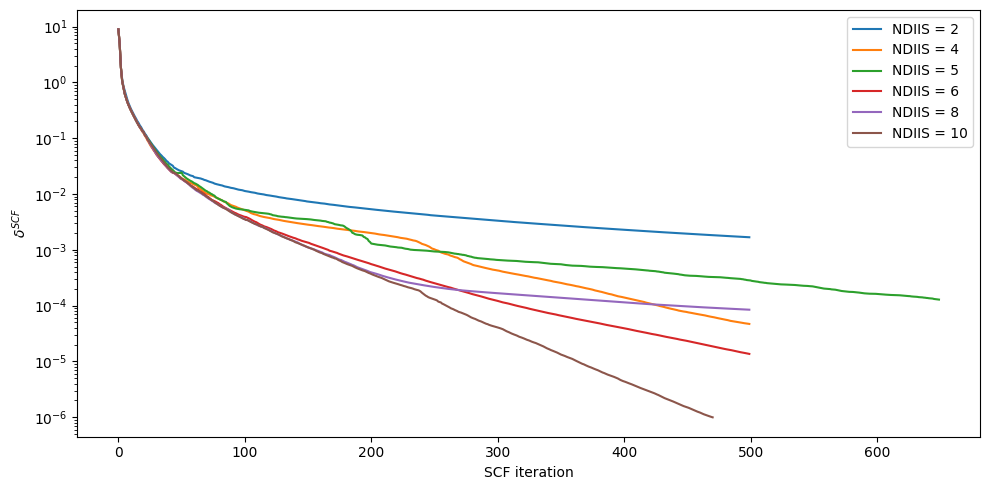

In [18]:
#@title DIIS increase test
#@markdown $\approx$ 5min (not required)
#%%capture
tmp = epipy("fixed_6OUH.gro","6OUH.top",convert=True,gen_idc=True)
out = []
for i in range(0,10,2):
  tmp.report(f'ndiis_{i}')
  tmp.ndiis = i
  tmp.kernel()
  out.append(tmp.err())

fig,ax = plt.subplots(figsize=(10,5))
ii = [i for i in range(0,10,2)]
for i,vals in zip(ii,out[1:]):
  ax.plot(vals,label=f"NDIIS = {i+2}")
  if i == 2: # we will show our errors in order (for asthetic reasons)
    ax.plot(lscf_err,label="NDIIS = 5")
ax.plot(diis_scf_err,label="NDIIS = 10")

ax.set_yscale('log')
ax.set_xlabel('SCF iteration')
ax.set_ylabel('$\delta^{SCF}$')
ax.legend()
fig.tight_layout()

**visualizing resutls**

* lets extract our atomic-density from the calculation

In [19]:
g_r = pdb.select_grid('guv')

* we can now visualize our results

Text(0.5, 0.98, '$g(\\vec{r})$ at slice 27 $\\mathring{A}$')

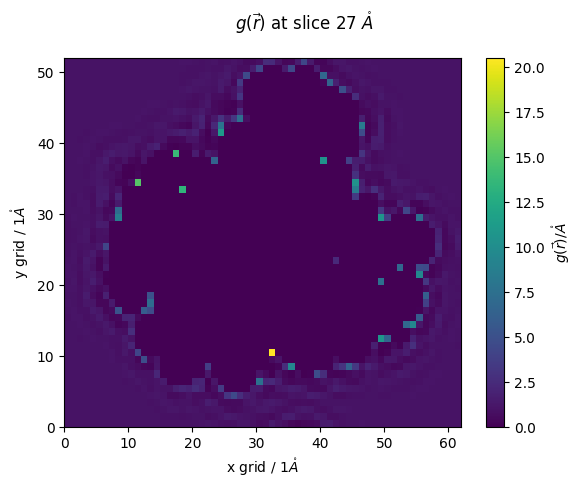

In [20]:
z_slice = 27 # @param {type:"slider", min:1, max:91, step:1}
fig,ax = plt.subplots()
#z_slice = 10
p = ax.pcolormesh(g_r[z_slice])
ax.set_ylabel(f'y grid / {pdb.resolution}$\\mathring{{A}}$')
ax.set_xlabel(f'x grid / {pdb.resolution}$\\mathring{{A}}$')
#ax.set_ylim(20,100)
#ax.set_xlim(10,65)
fig.colorbar(p,ax=ax, label="$g(\\vec{r})/\\mathring{{A}}$")
fig.suptitle(f'$g(\\vec{{r}})$ at slice {z_slice*pdb.resolution} $\\mathring{{A}}$')

* lets make use of epipy's select commands to investigate our RISM calculation
* epipy uses similar selection language to MDAnalysis and MDtraj
* here, we will select densities around 4A of all of our proteins residues

In [21]:
selected_grid = pdb.select_grid('guv around 4 resname LYS')

Text(0.5, 1.0, '$g(\\vec{r})$ at slice 25 $\\mathring{A}$')

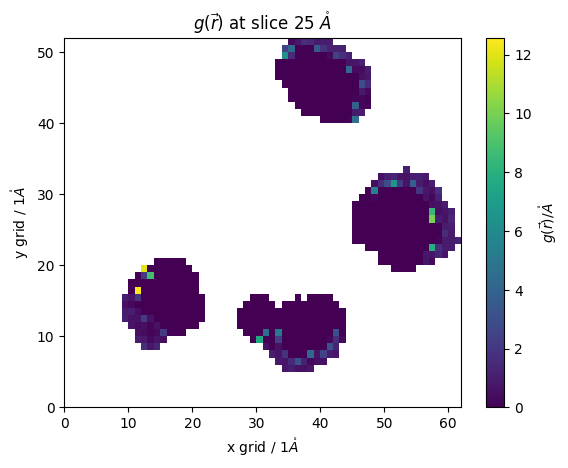

In [22]:
#@markdown lets vizualize our selected areas
z_slice = 25 # @param {type:"slider", min:0, max:91, step:1}
fig,ax = plt.subplots()#figsize=(10,3))
#z_slice = 10
p = ax.pcolormesh(selected_grid[z_slice])
ax.set_ylabel(f'y grid / {pdb.resolution}$\\mathring{{A}}$')
ax.set_xlabel(f'x grid / {pdb.resolution}$\\mathring{{A}}$')
#ax.set_ylim(None,20)#,100)
#ax.set_xlim(None,20)#10,65)
fig.colorbar(p,ax=ax, label="$g(\\vec{r})/\\mathring{{A}}$")
ax.set_title(f'$g(\\vec{{r}})$ at slice {z_slice*pdb.resolution} $\\mathring{{A}}$')


* this allows us to better analyze our system
* lets say for example, we want to see our $g(r)$ around our individual residues (≈ 20s)

Text(0.5, 1.0, 'Mean $g(\\vec{r})$ in  first solvation shell')

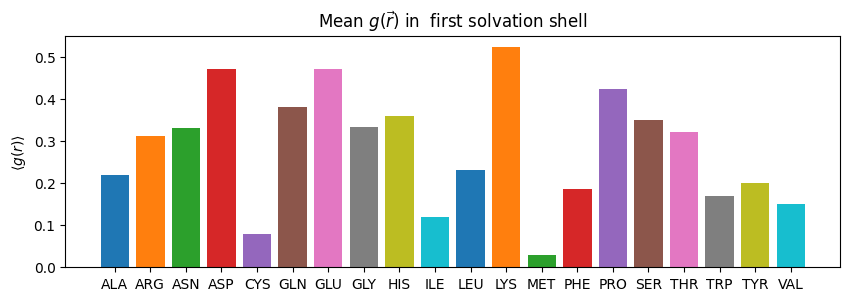

In [37]:
#@markdown
# first we create a list of the residues that are in our protei
pdb_residues = "ALA ARG ASN ASP CYS GLN GLU GLY HIS ILE LEU LYS MET PHE PRO SER THR TRP TYR VAL"
pdb_residues = pdb_residues.split()
# then make a dictionary of these names
density_dict = dict(zip(pdb_residues,[[] for _ in pdb_residues]))

for name in pdb_residues:
  ss = pdb.select_grid(f'guv around 4 resname {name}')
  # when doing this calculation we must ignore the NaN values
  density_dict[name] = np.ma.array(ss, mask=np.isnan(ss)).mean()
  # we will just take the mean value of our g(r)

fig,ax = plt.subplots(figsize=(10,3))
for name in density_dict.keys():
  ax.bar(name, density_dict[name])
ax.set_ylabel("$\\langle g(r)\\rangle$")
ax.set_title("Mean $g(\\vec{r})$ in  first solvation shell")

* we can select other values too, for example free energy around our residues

Text(0.5, 1.0, 'Mean $U(\\vec{r})$ in  first solvation shell')

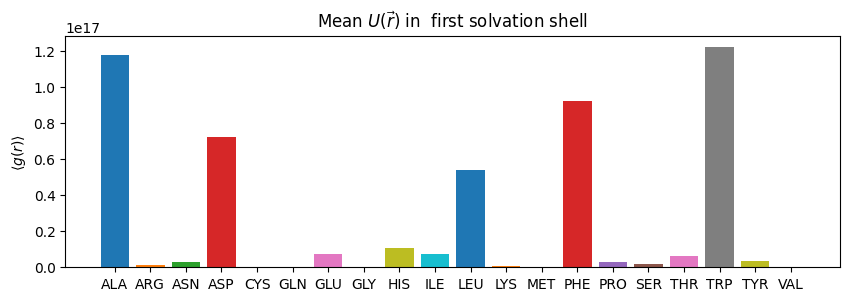

In [38]:
#@markdown
# first we create a list of the residues that are in our protein
pdb_residues = "ALA ARG ASN ASP CYS GLN GLU GLY HIS ILE LEU LYS MET PHE PRO SER THR TRP TYR VAL"
pdb_residues = pdb_residues.split()
density_dict = dict(zip(pdb_residues,[[] for _ in pdb_residues]))

for name in pdb_residues:
  ss = pdb.select_grid(f'uuv around 4 resname {name}')
  # when doing this calculation we must ignore the NaN values
  density_dict[name] = np.ma.array(ss, mask=np.isnan(ss)).mean()
  # we will just take the mean value of our g(r)

fig,ax = plt.subplots(figsize=(10,3))
for name in density_dict.keys():
  ax.bar(name, density_dict[name])
ax.set_ylabel("$\\langle g(r)\\rangle$")
ax.set_title("Mean $U(\\vec{r})$ in  first solvation shell")

* Now lets place waters on our grid
* we will select the top 100 atomic-density ( $g(\vec{r})$ ) peaks and place oxygen

In [26]:
number_waters_to_place = 300
placed_waters = pdb.placement(number_waters_to_place,filename='guv_diis_increase_pdb.txt',write_pdb=True,outname='placed_waters')

* lets use our selection commands to get our free energy values of the waters we just placed
* here, we use the coordinates from our placement, and use them to select the energies from our calculation

(-5.0, 20.0)

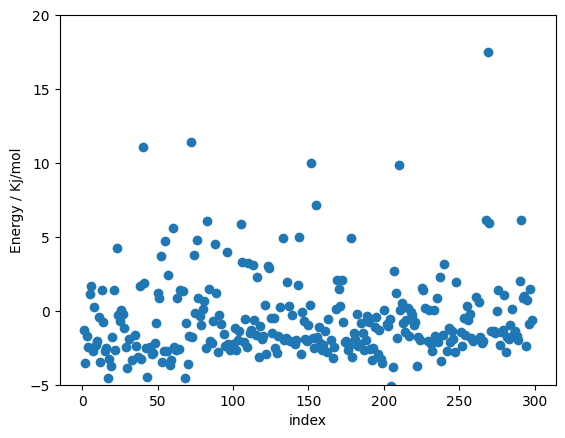

In [35]:
placed_water_energies = pdb.select_grid('uuv get',placed_waters)
fig,axs = plt.subplots()
axs.scatter(np.arange(len(placed_water_energies)),placed_water_energies)
axs.set_xlabel("index")
axs.set_ylabel("Energy / Kj/mol")
axs.set_ylim(-5,20)

* we can now add these energies into our waters pdb as tempfactors
* this is the easiest way to vizualize them in VMD/PyMol
* for our jupyter embedded model we will just select the water with the highest energy

# DONE

We encourage you to play around with this tutorial and substitute your own PDB file  


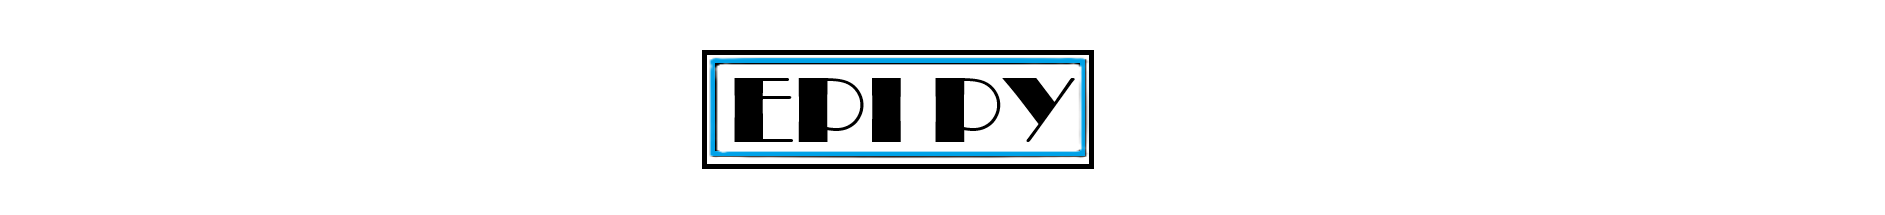